In [1]:
from sentinelhub import SHConfig

INSTANCE_ID = ''

if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [349]:
import datetime
import json
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sb

from shapely.geometry import Polygon
from sentinelhub import WmsRequest, WcsRequest, FisRequest, MimeType, CRS, BBox, Geometry

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression

In [112]:
from matplotlib import style
style.use('bmh')
from pylab import rcParams
rcParams['figure.figsize'] = 15,6

## Extraer listado de fechas de archivo Excel

In [4]:
fechas = pd.read_excel('SentinelHubImage-available_dates.xlsx')
fechas

,id,farm,_date,_datetime_utc,validated
0,14180,163,2020-04-20,2020-04-20 15:26:52,1
1,13892,163,2020-04-15,2020-04-15 15:26:57,1
2,11899,163,2020-03-11,2020-03-11 15:26:55,1
3,11202,163,2020-02-15,2020-02-15 15:26:51,1
4,10946,163,2020-02-10,2020-02-10 15:26:52,1
...,...,...,...,...,...
84,8513,163,2016-12-22,2016-12-22 15:23:53,1
85,8514,163,2016-12-02,2016-12-02 15:21:03,1
86,8515,163,2016-11-22,2016-11-22 15:19:30,1
87,8518,163,2016-09-13,2016-09-13 15:26:48,1


In [279]:
listado_fechas = fechas['_date'].sort_values().to_list()
print(listado_fechas[:5])
print(listado_fechas[-5:])

['2016-07-15', '2016-09-13', '2016-11-22', '2016-12-02', '2016-12-22']
['2020-02-10', '2020-02-15', '2020-03-11', '2020-04-15', '2020-04-20']


## Extraer información relevante de cada lote desde archivo JSON

In [280]:
#Leer archivo
with open('farm_map.json', 'r') as myfile:
    farm_map = myfile.read()
    
#Parsing
farm_map_data = json.loads(farm_map)

for x in farm_map_data:
    print(x)
    print(type(farm_map_data[x]))
    print(len(farm_map_data[x]))
    print(farm_map_data[x])
    print('\n')

crs
<class 'dict'>
2
{'type': 'name', 'properties': {'name': 'EPSG:4326'}}


setup
<class 'dict'>
9
{'variable': {'id': 551, 'name': 'Rendimiento', 'category': 'Production', 'requires_time': False, 'project': 243, 'cartography': 747, 'measurement_unit': 'Kg/Ha'}, 'cartography': {'id': 747, 'name': 'Cartografía de lote', 'unit_name': 'lote'}, 'measurement_unit': 'Kg/Ha', 'legend': [], 'data_type': 'float', 'real_setup': False, 'inverted_legend': False, 'display_total_in_dashboard': False, 'variable_group': None}


type
<class 'str'>
17
FeatureCollection


features
<class 'list'>
33
[{'geometry': {'type': 'Polygon', 'coordinates': [[[-75.6396578867764, -14.199701335951724], [-75.64231663022875, -14.20062882414364], [-75.64298408105815, -14.198802571721302], [-75.64032613621433, -14.197876401443217], [-75.6396578867764, -14.199701335951724]]]}, 'type': 'Feature', 'properties': {'values': [{'value': 3581.158766439885, 'variety': {}, 'measurement_unit': 'Kg/Ha', 'date_stamp': '2019-09-19', 

In [281]:
features = farm_map_data['features']

for x in features[0]:
    print(x)
    print(features[0][x])
    print('\n')

geometry
{'type': 'Polygon', 'coordinates': [[[-75.6396578867764, -14.199701335951724], [-75.64231663022875, -14.20062882414364], [-75.64298408105815, -14.198802571721302], [-75.64032613621433, -14.197876401443217], [-75.6396578867764, -14.199701335951724]]]}


type
Feature


properties
{'values': [{'value': 3581.158766439885, 'variety': {}, 'measurement_unit': 'Kg/Ha', 'date_stamp': '2019-09-19', 'metadata': None, 'time_stamp': None}], 'unit': {'state': {'area': 6.53060080697, 'year_of_planting': ['2019'], 'variety': ['hass, fuerte, zutano']}, 'metadata': [{'level_name': 'empresa', 'name': 'agricola chapi', 'level': 2}, {'level_name': 'fundo', 'name': 'don ernesto', 'level': 1}, {'level_name': 'grupo', 'name': 'pal-1', 'level': 0}, {'level_name': 'lote', 'name': '36', 'level': -1}], 'id': 90214, 'full_name': 'lote AGRICOLA CHAPI.DON ERNESTO.PAL-1.36', 'name': 'AGRICOLA CHAPI.DON ERNESTO.PAL-1.36'}}




In [282]:
lista_ids = []
lista_rend = []
lista_coordenadas = []

for feature in features:
    propiedades = feature['properties']   
    #ID de cada lote
    id_lote = propiedades['unit']['id']
    lista_ids.append(id_lote)
    #Rendimiento de cada lote
    rend = propiedades['values'][0]['value']
    lista_rend.append(rend)
    #Coordenadas de cada lote
    coordenadas = feature['geometry']
    lista_coordenadas.append(coordenadas)

In [313]:
columns = ['Rend_Kg/Ha', 'id']
data_lotes = pd.DataFrame(list(zip(lista_rend, lista_ids)), columns=columns)
data_lotes.set_index('id', inplace=True)
data_lotes.head()

,Rend_Kg/Ha
id,
90214,3581.158766
90215,4037.375179
90216,4658.420440
90217,4196.272166
90218,4744.580970


In [284]:
dict_coord_lotes = dict(zip(lista_ids, lista_coordenadas))
dict_coord_lotes

{90214: {'type': 'Polygon',
  'coordinates': [[[-75.6396578867764, -14.199701335951724],
    [-75.64231663022875, -14.20062882414364],
    [-75.64298408105815, -14.198802571721302],
    [-75.64032613621433, -14.197876401443217],
    [-75.6396578867764, -14.199701335951724]]]},
 90215: {'type': 'Polygon',
  'coordinates': [[[-75.64231663022875, -14.20062882414364],
    [-75.64498414018, -14.20155933262638],
    [-75.64565052221766, -14.199731664766256],
    [-75.64298408105815, -14.198802571721302],
    [-75.64231663022875, -14.20062882414364]]]},
 90216: {'type': 'Polygon',
  'coordinates': [[[-75.63898926117189, -14.201527268326426],
    [-75.64164955317383, -14.202454024468352],
    [-75.64231663022875, -14.20062882414364],
    [-75.6396578867764, -14.199701335951724],
    [-75.63898926117189, -14.201527268326426]]]},
 90217: {'type': 'Polygon',
  'coordinates': [[[-75.64164955317383, -14.202454024468352],
    [-75.64431888131925, -14.203383890611855],
    [-75.64498414018, -14.20155

## Preparar información geométrica para Sentinel Hub

In [285]:
dict_geometrias = {}
for key in dict_coord_lotes:
    geometria = Geometry(geometry=dict_coord_lotes[key], crs=CRS.WGS84)
    dict_geometrias[key] = geometria
    
dict_bbox = {}
for key in dict_geometrias:
    bbox = dict_geometrias[key].bbox
    dict_bbox[key] = bbox

## 1. Extraer las bandas de satélite de Sentinel 2

In [ ]:
dict_bandas_lotes = {}
for key in dict_bbox:
    dict_bandas_fechas = {}  
    for fecha in listado_fechas:
        wms_bands_request = WmsRequest(
            layer='BANDS-S2-L1C',
            bbox=dict_bbox[key],
            time=fecha,
            width=512,
            image_format=MimeType.TIFF_d32f,
            config=config
        )

        wms_bands_data = wms_bands_request.get_data()
        dict_bandas_fechas[fecha] = wms_bands_data
        
    dict_bandas_lotes[key] = dict_bandas_fechas

In [ ]:
dict_bandas_lotes

In [ ]:
with open('bandas_sentinel2.json', 'w') as f:
    json.dump(dict_bandas_lotes, f, indent=1)

In [ ]:
dict_bandas_lotes[90219]['2016-07-15']

## 2. Extraer los valores de NDVI promedio para cada lote para cada una de las fechas. Cada lote es un feature del geojson adjunto en el repositorio.

In [107]:
dict_ndvi_lote = {}

for key in dict_geometrias:
    dict_ndvi_fecha = {}
    
    for fecha in listado_fechas:
        fis_request = FisRequest(
            layer='NDVI',
            geometry_list=[dict_geometrias[key]],
            time=fecha,
            config=config
        )

        fis_data = fis_request.get_data()
        mean = fis_data[0]['C0'][0]['basicStats']['mean']
        dict_ndvi_fecha[fecha] = mean
        
    dict_ndvi_lote[key] = dict_ndvi_fecha

In [108]:
dict_ndvi_lote

{90214: {'2016-07-15': 0.5802835013214546,
  '2016-09-13': 0.5100757551505218,
  '2016-11-22': 0.6323086213802824,
  '2016-12-02': 0.5901211831236338,
  '2016-12-22': 0.5486487163533516,
  '2017-01-01': 0.5347561464945144,
  '2017-02-20': 0.5799129907626747,
  '2017-04-01': 0.5939339828515838,
  '2017-07-10': 0.5723851632234479,
  '2017-08-19': 0.5681322215140359,
  '2017-09-08': 0.49964058021540153,
  '2017-09-28': 0.493404136421595,
  '2017-10-03': 0.4614733762977538,
  '2017-10-18': 0.5149048321954803,
  '2017-11-07': 0.5612782287326724,
  '2017-11-12': 0.5381375851915231,
  '2018-01-21': 0.5516450425645864,
  '2018-01-26': 0.5963930288950602,
  '2018-03-02': 0.5773225188994215,
  '2018-03-22': 0.5261202955993092,
  '2018-03-27': 0.5510887360975103,
  '2018-04-11': 0.5804471703189794,
  '2018-04-16': 0.5808690896170527,
  '2018-04-21': 0.48679794576378255,
  '2018-05-11': 0.5944717315028191,
  '2018-05-16': 0.6051347989270845,
  '2018-05-21': 0.5714634113608976,
  '2018-06-05': 0.60

In [109]:
with open('ndvi_promedios.json', 'w') as f:
    json.dump(dict_ndvi_lote, f, indent=1)

In [110]:
dict_ndvi_lote[90219]['2016-07-15']

0.6129635642629017

## 3. Guardar las imágenes de NDVI de cada lote y cada fecha.

In [ ]:
for key in dict_bbox:   
    for fecha in listado_fechas:
        wms_ndvi_request = WmsRequest(
            data_folder='NDVI_imgs/lote_{}/fecha_{}'.format(str(key), fecha),
            layer='NDVI',
            bbox=dict_bbox[key],
            time=fecha,
            width=512,
            config=config
        )
        
        wms_ndvi_request.save_data()

## 4. Hacer un análisis de los datos obtenidos para obtener insights de cómo el NDVI se comporta en el tiempo para los diferentes lotes.

Primero construyamos un dataframe el cual contendrá toda la información recolectada de los NDVI promedio por fecha y por lote. Cada columna del dataframe corresponderá a un determinado lote, mientras que se usarán las fechas a modo de índice.

In [180]:
dict_series = {}

for key in dict_ndvi_lote:
    serie = pd.Series(dict_ndvi_lote[key])
    dict_series[key] = serie
    
df = pd.DataFrame(dict_series)
df.reset_index(inplace=True)
df['Fecha'] = pd.to_datetime(df['index'])
df.drop(['index'], axis=1, inplace=True)
df.set_index('Fecha', inplace=True)
df

,90214,90215,90216,90217,90218,90219,90221,90222,90224,90225,...,90236,90237,90238,90239,90240,90241,90242,90243,90244,90249
Fecha,,,,,,,,,,,,,,,,,,,,,
2016-07-15,0.580284,0.605119,0.612188,0.621504,0.599143,0.612964,0.597073,0.621617,0.593097,0.621283,...,0.065132,0.055223,0.055493,0.059479,0.129690,0.070310,0.062103,0.128845,0.069301,0.082794
2016-09-13,0.510076,0.525745,0.537810,0.535444,0.524066,0.529593,0.517273,0.522777,0.501202,0.508436,...,0.050475,0.044695,0.047841,0.050305,0.088682,0.057583,0.050423,0.081531,0.054865,0.065821
2016-11-22,0.632309,0.644213,0.680864,0.661832,0.664956,0.659722,0.647390,0.639082,0.660065,0.656783,...,0.060189,0.054855,0.055877,0.059152,0.100697,0.068887,0.062149,0.108802,0.070113,0.066992
2016-12-02,0.590121,0.606996,0.632815,0.624022,0.616603,0.624082,0.599714,0.601086,0.616156,0.622377,...,0.045429,0.042664,0.041099,0.047566,0.104722,0.058750,0.050135,0.116921,0.053997,0.059165
2016-12-22,0.548649,0.565943,0.594028,0.591772,0.587116,0.598871,0.573825,0.576819,0.593378,0.594207,...,0.044005,0.041329,0.041364,0.045229,0.155513,0.056107,0.049936,0.191102,0.055295,0.055423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-10,0.579181,0.587254,0.607601,0.600669,0.608119,0.613729,0.604259,0.602666,0.580177,0.564713,...,0.272005,0.265664,0.263715,0.323101,0.358729,0.307809,0.306934,0.389361,0.298767,0.322829
2020-02-15,0.570878,0.580773,0.593126,0.588317,0.592576,0.596309,0.581937,0.581438,0.555033,0.544445,...,0.265394,0.261164,0.262623,0.313408,0.355723,0.306593,0.302854,0.385637,0.303810,0.325763
2020-03-11,0.572730,0.578686,0.599904,0.593784,0.602877,0.600772,0.596275,0.588243,0.569437,0.544784,...,0.277177,0.277854,0.285698,0.325452,0.369982,0.320250,0.307525,0.391267,0.319033,0.336004


Ahora grafiquemos todas las columnas en un sólo gráfico

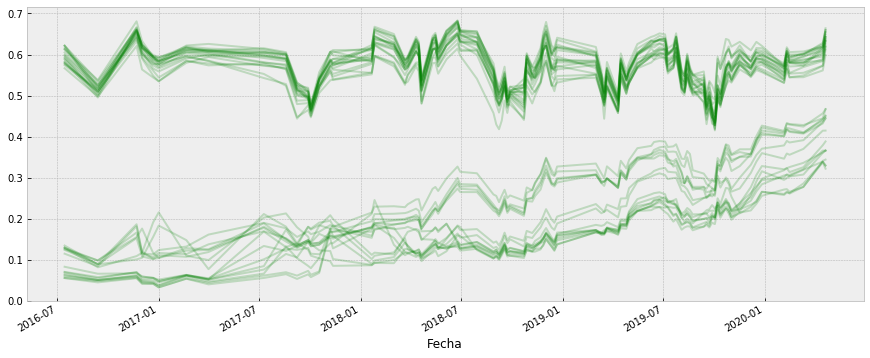

In [286]:
for column in df:
    df[column].plot(color='green', alpha=0.2)

Como se puede apreciar en el gráfico anterior, se tienen dos grupos de lotes:
    
* El primero concentra lotes con un NDVI promedio aparentemente constante a lo largo del tiempo y con valores superiores a los del segundo grupo.

* El segundo grupo de lotes es un poco más difuso e incluso parece que se podría dividir en dos grupos más, pero en general se puede apreciar una tendencia creciente en el tiempo.

Ahora, le daremos un vistazo a los boxplots e histogramas de los valores NDVI promedio para cada lote.

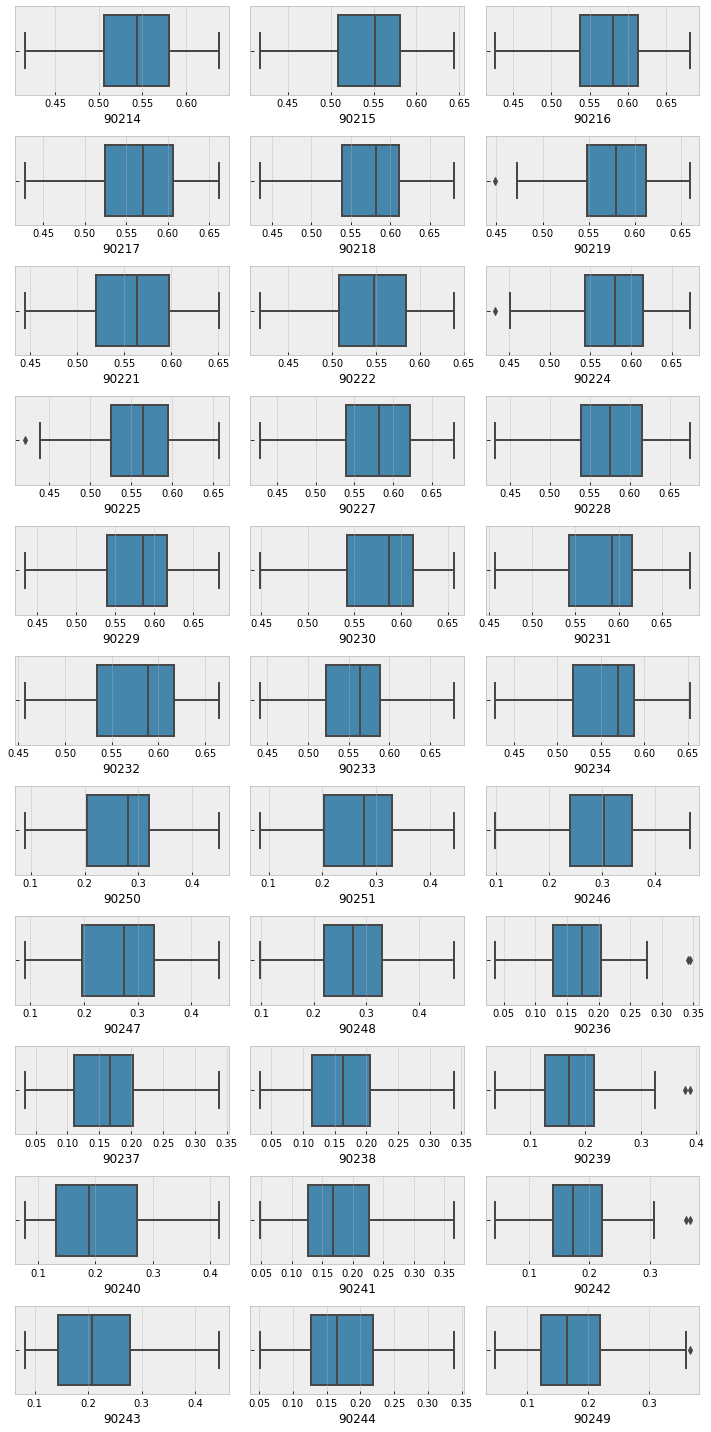

In [137]:
fig, axes = plt.subplots(11, 3, figsize=(10, 20))

for ax, column in zip(axes.flatten(), df):
    sb.boxplot(df[column], ax=ax)
    
fig.tight_layout()

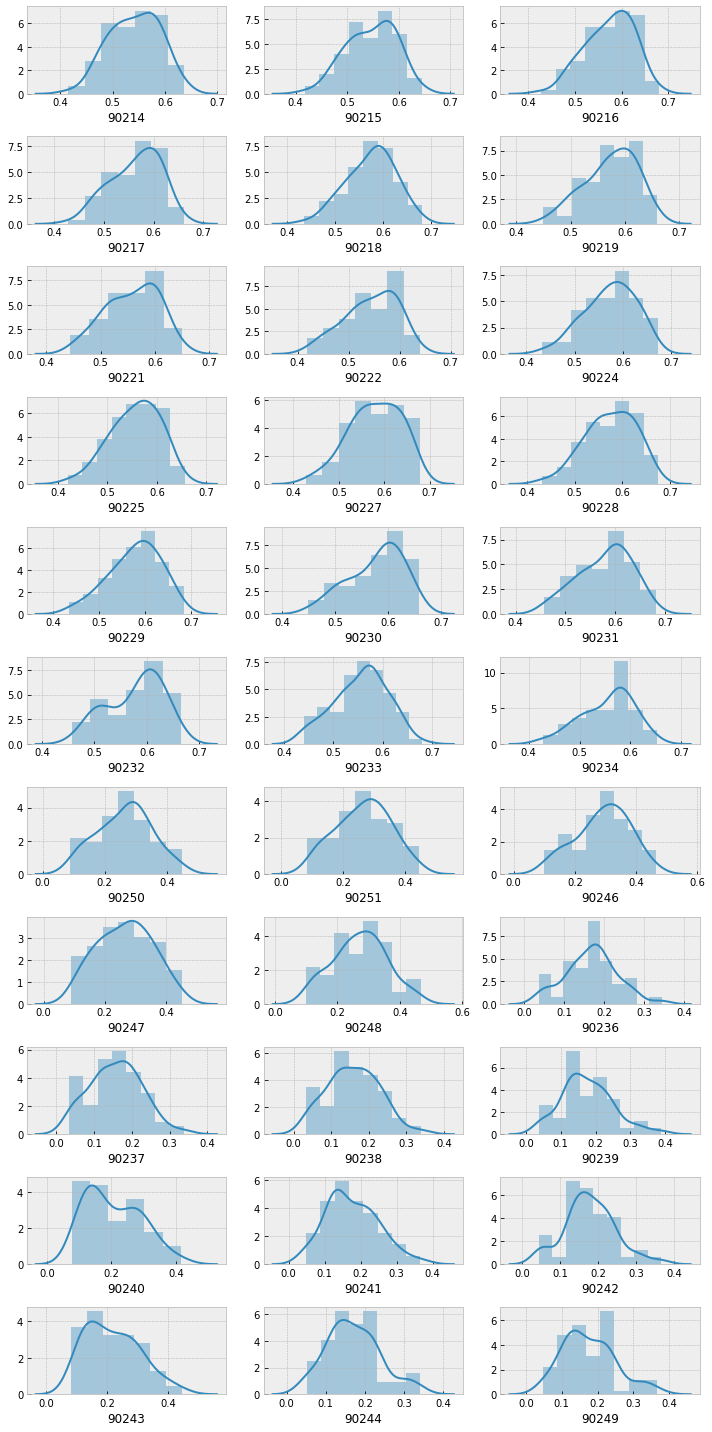

In [141]:
fig, axes = plt.subplots(11, 3, figsize=(10, 20))

for ax, column in zip(axes.flatten(), df):
    sb.distplot(df[column], ax=ax)
    
fig.tight_layout()

En general, para cada lote la distribución de los datos no está muy lejos de ser normal, con presencia de valores atípicos en pocos casos, lo que concuerda con lo observado en la primera gráfica.

Ahora dividiremos la data en dos grupos para analizarlos cada uno por separado.

### Grupo 01:

Como pudimos ver en la primera gráfica de líneas, hay un grupo de lotes en el cual todos los valores de NDVI promedio son mayores a 0.4, así que usaremos dicho criterio para dividir la data en los dos grupos ya comentados.

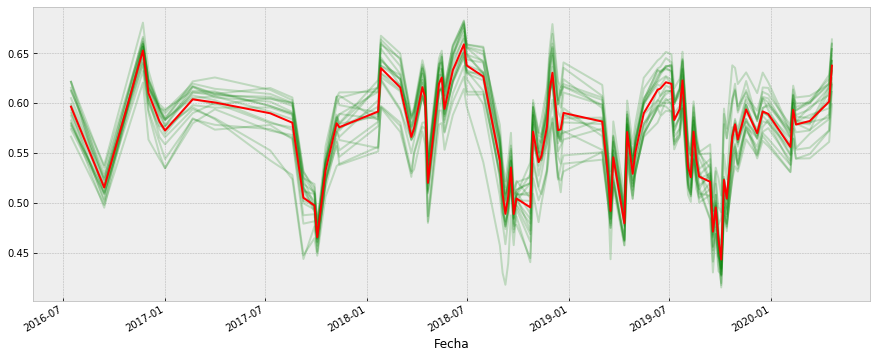

In [200]:
serie_bool = df.min()>0.4
lotes_grupo_01 = serie_bool[serie_bool==True].index.to_list()

df_lotes_grupo_01 = df[lotes_grupo_01]

# Crearemos una columna en la cual se calculará el valor promedio de todos los lotes para cada fecha,
# esto debido a que pensamos que dicho promedio nos ayudará a simplificar el modelado de la data,
# al tener todas las lineas de este grupo un comportamiento muy similar.
prom_lotes_grupo_01 = df_lotes_grupo_01.mean(axis=1)

# Graficamos todos los lotes de este grupo en un mismo gráfico
for column in df_lotes_grupo_01:
    df_lotes_grupo_01[column].plot(color='green', alpha=0.2)
    
# Graficamos la línea promedio con otro color para que resalte en el mismo gráfico
prom_lotes_grupo_01.plot(color='red')
plt.show()

En la gráfica podemos apreciar que existe una especie de componente de estacionalidad probablemente anual, en el que el valor mínimo anual se ubica aproximadamente en la mitad del segundo semestre. También en los años 2018 y 2019 se observa un mínimo relativo ubicado cerca de la mitad del primer semestre.

Ahora bien, para descartar cualquier comportamiento tendencial creciente o decreciente en el tiempo, aplicaremos el test de Dickey-Fuller aumentado a la serie promedio de todos los lotes de este grupo.

In [207]:
result = adfuller(prom_lotes_grupo_01)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.315530
p-value: 0.000417
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


De acuerdo a los resultados del test, podemos rechazar la hipótesis nula de que existe una raíz unitaria en la serie temporal con un nivel de confianza mayor al 99%, por tanto podemos considerar a la serie como estacionaria en el sentido que no posee una componente tendencial, aunque es evidente que este test no sirve para descartar el componente estacional que se puede apreciar en la gráfica lineal.

Para poder estudiar mejor la componente de estacionalidad de la data, lo que podemos hacer es "resamplear" la data, lo cual consiste en recalcular los datos para una frecuencia constante. Primero consideraremos una frecuencia mensual para el reampling de nuestros datos, por lo que se calculará el NDVI promedio mensual.

### Resampling de la data a una frecuencia mensual

In [268]:
resample = prom_lotes_grupo_01.resample('M')
#Calculamos el promedio mensual del NDVI
prom_mensual = resample.mean()
#Verificamos la existencia de datos nulos
prom_mensual.isnull().sum()

10

En este caso, el resampling de la data a una frecuencia mensual tiene la desventaja de que para algunos meses no se cuenta con datos para calcular el promedio. De todas formas realizaremos un gráfico para poder apreciar el comportamiento anual del índice.

Fecha
2016-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2017-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2018-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2019-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2020-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
Freq: A-DEC, dtype: object

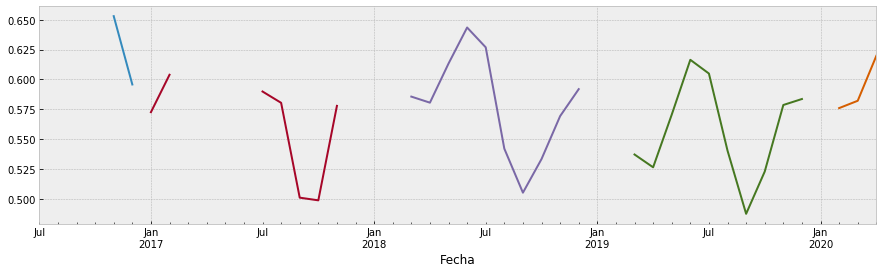

In [277]:
groups = prom_mensual.groupby(pd.Grouper(freq='A'))
groups.plot(figsize=(15,4))

In [278]:
groups.describe()

,count,mean,std,min,25%,50%,75%,max
Fecha,,,,,,,,
2016-12-31,4.0,0.590174,0.056498,0.515515,0.575731,0.596157,0.610600,0.652866
2017-12-31,8.0,0.565763,0.041889,0.499067,0.554823,0.579221,0.592642,0.603920
2018-12-31,11.0,0.582345,0.042197,0.505459,0.555805,0.585677,0.613392,0.643367
2019-12-31,10.0,0.556978,0.040426,0.487812,0.529325,0.555590,0.582425,0.616414
2020-12-31,3.0,0.592653,0.023609,0.576077,0.579137,0.582198,0.600941,0.619684


En el caso de los dos años para los que se tiene mayor cantidad de datos (2018 y 2019), se puede ver un claro comportamiento estacional en ambas gráficas. Para el resto de años lamentablemente no se cuenta con mayor información como para obtener alguna conclusión significativa, aparte del hecho de que en el año 2017 se repite la tendencia hacia un valor mínimo en el segundo semestre.

Ahora vamos a hacer otro resampling, pero en este caso se calculará el NDVI promedio bimestral.

Datos nulos: 0.


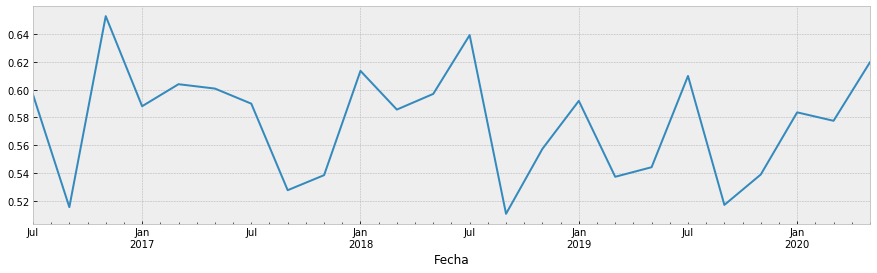

In [373]:
resample = prom_lotes_grupo_01.resample('2M')
#Calculamos el promedio bimestral del NDVI
prom_bimestral = resample.mean()
#Verificamos la existencia de datos nulos
print('Datos nulos: {}.'.format(prom_bimestral.isnull().sum()))
#Plot
prom_bimestral.plot(figsize=(15,4));

Fecha
2016-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2017-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2018-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2019-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
2020-12-31    AxesSubplot(0.125,0.125;0.775x0.755)
Freq: A-DEC, dtype: object

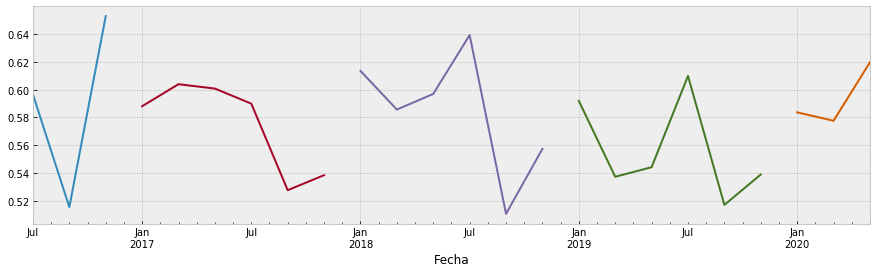

In [275]:
groups = prom_bimestral.groupby(pd.Grouper(freq='A'))
groups.plot(figsize=(15,4))

In [276]:
groups.describe()

,count,mean,std,min,25%,50%,75%,max
Fecha,,,,,,,,
2016-12-31,3.0,0.588297,0.069043,0.515515,0.556013,0.596511,0.624688,0.652866
2017-12-31,6.0,0.574821,0.033058,0.527695,0.550906,0.589010,0.598067,0.603920
2018-12-31,6.0,0.583918,0.045096,0.510711,0.564498,0.591313,0.609366,0.639229
2019-12-31,6.0,0.556576,0.035990,0.517124,0.537753,0.541602,0.580003,0.609852
2020-12-31,3.0,0.593655,0.022745,0.577607,0.580641,0.583674,0.601679,0.619684


En el caso del resampling bimestral, si bien nos lleva a unas conclusiones preliminares bastante similares a las del resampling mensual, tiene la ventaja de que al no poseer la serie valores nulos entonces podremos aplicar la herramienta **seasonal_decompose()** de la librería **statsmodels**, la cual nos ayudará a modelar el componente estacional de la data.

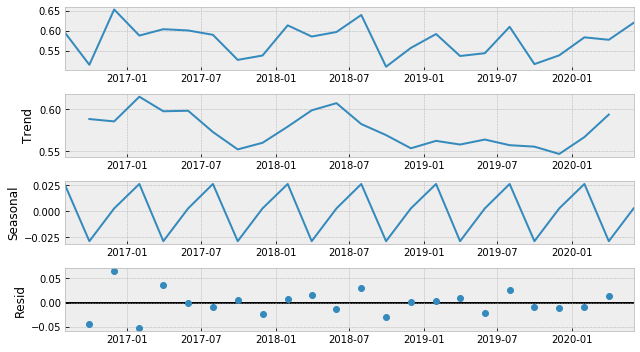

In [382]:
# En este caso, se considerará una estacionalidad semestral (3 períodos bimestrales)
result = seasonal_decompose(prom_bimestral, model='additive', period=3)
result.plot();

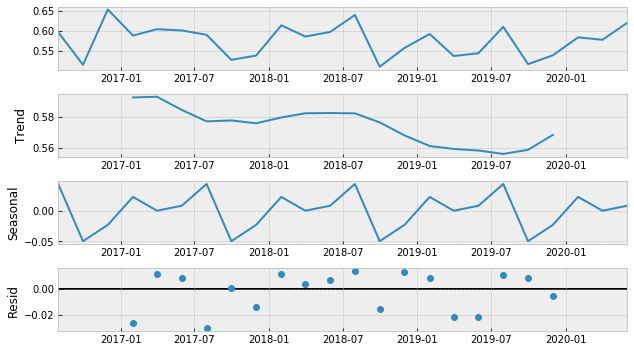

In [383]:
# En este caso, se considerará una estacionalidad anual (6 períodos bimestrales)
result = seasonal_decompose(prom_bimestral, model='additive', period=6)
result.plot();

### Grupo 02:

En este grupo simplemente irá el resto de lotes que no pertenecen al grupo 01. Crearemos el dataframe correspondiente y graficaremos las series temporales de todos los lotes, incluyendo además una línea que represente el promedio de todas las series, esto para ver si la misma nos puede ayudar a simplificar el análisis de este grupo.

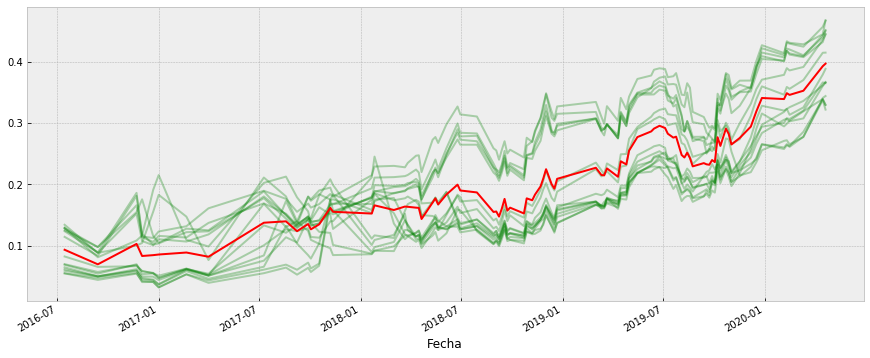

In [205]:
lotes_grupo_02 = serie_bool[serie_bool==False].index.to_list()

df_lotes_grupo_02 = df[lotes_grupo_02]

prom_lotes_grupo_02 = df_lotes_grupo_02.mean(axis=1)

for column in df_lotes_grupo_02:
    df_lotes_grupo_02[column].plot(color='green', alpha=0.3)
    
prom_lotes_grupo_02.plot(color='red')
plt.show()

A grosso modo podemos considerar que la serie promedio logra captar el comportamiento de todas las series, por lo que la utilizaremos para continuar con el análisis. Si bien la presencia de un componente tendencial creciente es clara, igual aplicaremos el test de Dickey-Fuller aumentado para ver las estadísticas que arroja.

In [209]:
result = adfuller(prom_lotes_grupo_02)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.015164
p-value: 0.957260
Critical Values:
	1%: -3.507
	5%: -2.895
	10%: -2.585


Con el valor-p arrojado por el test, obviamente no podemos rechazar la hipótesis nula del mismo, por tanto debemos tomar en cuenta la existencia de un componente tendencial en nuestra serie temporal. Ahora busquemos la manera de modelar dicho componente, para lo cual primero debemos "resamplear" nuestra data a una frecuencia constante, en este caso bimestral para que no existan valores nulos en la nueva serie.

Datos nulos: 0.


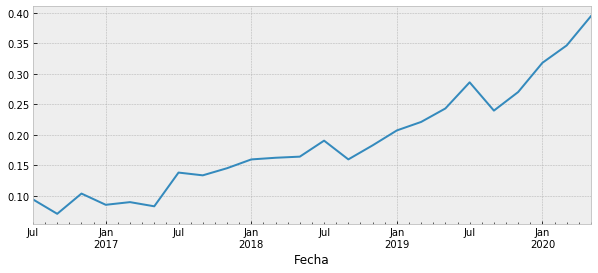

In [392]:
resample = prom_lotes_grupo_02.resample('2M')
#Calculamos el promedio bimestral del NDVI
prom_bimestral = resample.mean()
#Verificamos la existencia de datos nulos
print('Datos nulos: {}.'.format(prom_bimestral.isnull().sum()))
#Plot
prom_bimestral.plot(figsize=(10,4));

Ahora probemos con un modelo de regresión lineal para ver qué tan bien se ajusta a la tendencia lineal de nuestra data.

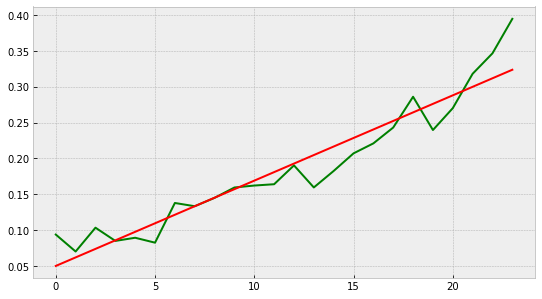

In [393]:
X = [i for i in range(0, len(prom_bimestral))]
X = np.reshape(X, (len(X), 1))
y = prom_bimestral.values

# fit linear model
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)

# plot trend
plt.plot(y, color='green')
plt.plot(trend, color='red')
plt.show()

En principio el modelo lineal no parece ser una mala opción para representar la componente tendencial de nuestra data, sin embargo al último tramo se ve un aumento más que lineal de la tendencia, que tal vez pueda ser mejor representado por un modelo exponencial.

## Relación entre NDVI y rendimiento de los cultivos

Veamos si existe una relación entre el NDVI promedio de un lote y el rendimiento de los cultivos del mismo. Para ello estudiaremos la correlación entre los valores NDVI promedio de cada lote correspondientes al año 2019 y los valores de rendimiento obtenidos del archivo JSON, cuya fecha de estampado se indica en el mismo archivo que es "2019-09-19".

In [357]:
rcParams['figure.figsize'] = 9,5

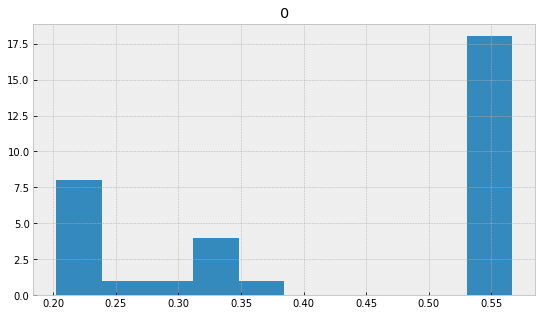

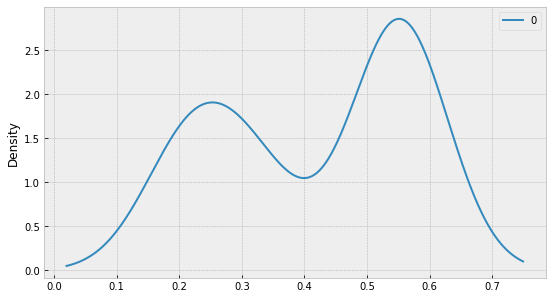

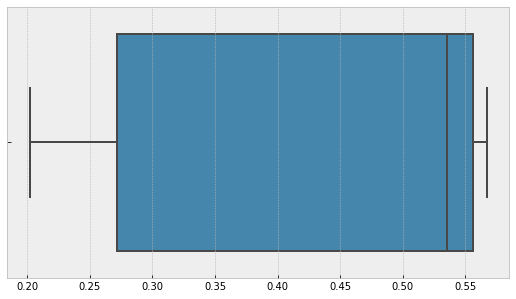

In [375]:
ndvi_prom_2019 = df.groupby(pd.Grouper(freq='A')).mean().iloc[3]
df_ndvi_prom_2019 = pd.DataFrame(ndvi_prom_2019.values)

# histograma
df_ndvi_prom_2019.hist()
plt.show()

# gráfico de densidad
df_ndvi_prom_2019.plot(kind='kde')
plt.show()

# boxplot
sb.boxplot(df_ndvi_prom_2019)
plt.show()

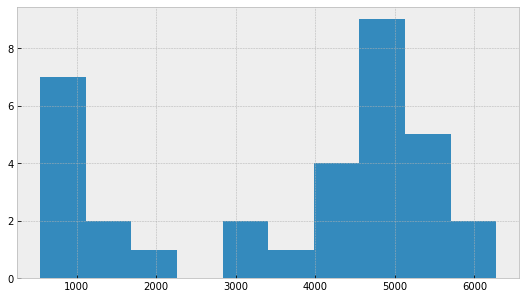

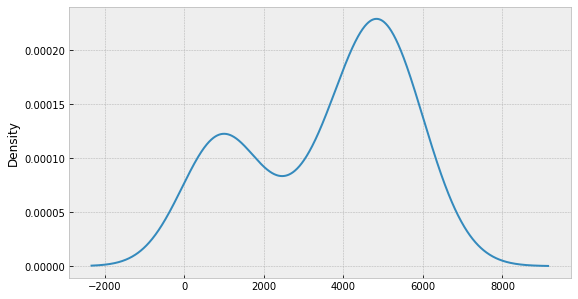

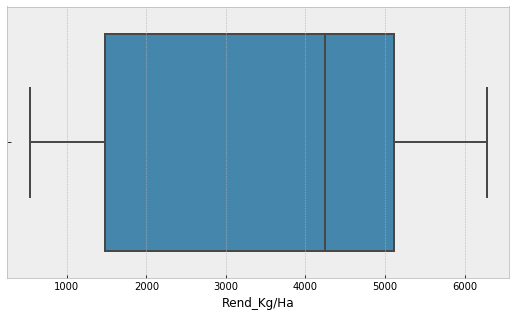

In [376]:
rendimiento = data_lotes['Rend_Kg/Ha']

# histograma
rendimiento.hist()
plt.show()

# gráfico de densidad
rendimiento.plot(kind='kde')
plt.show()

# boxplot
sb.boxplot(rendimiento)
plt.show()

In [328]:
data_lotes['NDVI_prom_2019'] = ndvi_prom_2019
print(data_lotes.corr())
print(data_lotes.corr(method='spearman'))

                Rend_Kg/Ha  NDVI_prom_2019
Rend_Kg/Ha        1.000000        0.813155
NDVI_prom_2019    0.813155        1.000000
                Rend_Kg/Ha  NDVI_prom_2019
Rend_Kg/Ha        1.000000        0.813837
NDVI_prom_2019    0.813837        1.000000


### Lotes grupo 01:

In [367]:
data_lotes_grupo_01 = data_lotes.loc[lotes_grupo_01]
data_lotes_grupo_01.describe()

,Rend_Kg/Ha,NDVI_prom_2019
count,18.000000,18.000000
mean,4738.766843,0.551927
std,909.189324,0.011604
min,2970.080776,0.531265
25%,4202.887167,0.541388
50%,4851.936773,0.555893
75%,5380.123334,0.560911
max,6276.873685,0.566859


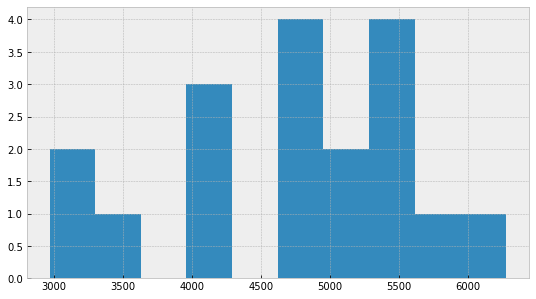

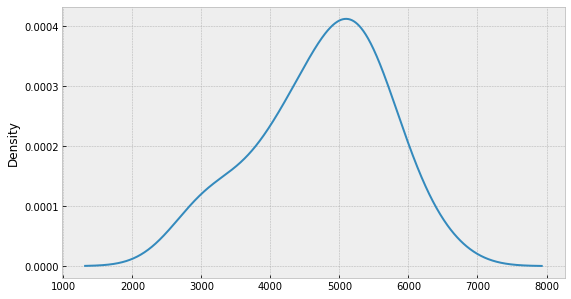

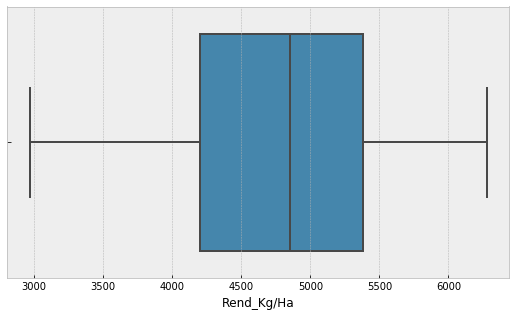

In [366]:
rendimiento = data_lotes_grupo_01['Rend_Kg/Ha']

# histograma
rendimiento.hist()
plt.show()

# gráfico de densidad
rendimiento.plot(kind='kde')
plt.show()

# boxplot
sb.boxplot(rendimiento)
plt.show()

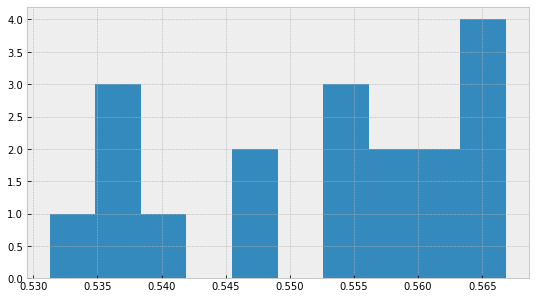

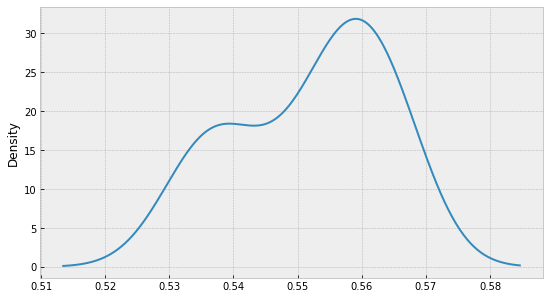

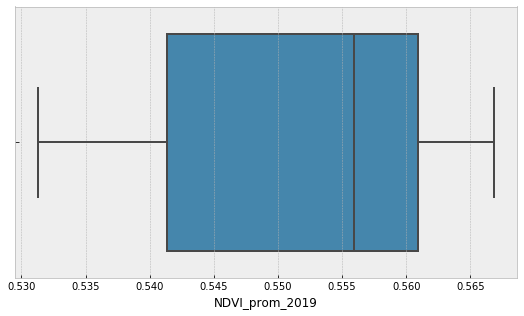

In [365]:
ndvi_2019 = data_lotes_grupo_01['NDVI_prom_2019']

# histograma
ndvi_2019.hist()
plt.show()

# gráfico de densidad
ndvi_2019.plot(kind='kde')
plt.show()

# boxplot
sb.boxplot(ndvi_2019)
plt.show()

In [345]:
print(data_lotes_grupo_01.corr())
print(data_lotes_grupo_01.corr(method='spearman'))

                Rend_Kg/Ha  NDVI_prom_2019
Rend_Kg/Ha        1.000000        0.450859
NDVI_prom_2019    0.450859        1.000000
                Rend_Kg/Ha  NDVI_prom_2019
Rend_Kg/Ha        1.000000        0.541796
NDVI_prom_2019    0.541796        1.000000


### Lotes grupo 02:

In [364]:
data_lotes_grupo_02 = data_lotes.loc[lotes_grupo_02]
data_lotes_grupo_02.describe()

,Rend_Kg/Ha,NDVI_prom_2019
count,15.000000,15.000000
mean,2205.843095,0.259994
std,1842.123470,0.054748
min,537.120263,0.202180
25%,763.130250,0.214991
50%,1151.521331,0.223526
75%,4417.384222,0.320193
max,5116.360841,0.349021


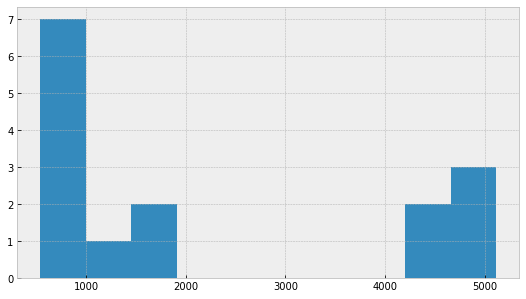

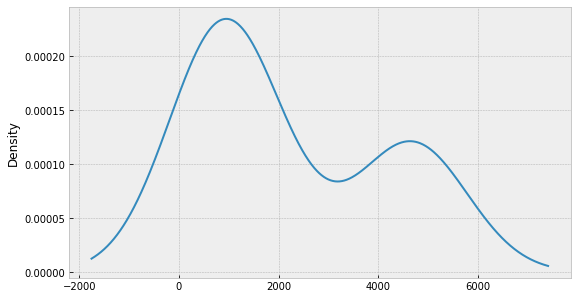

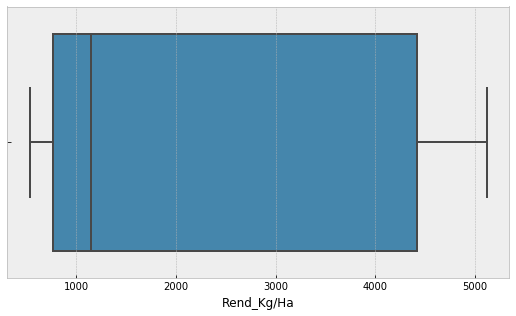

In [362]:
rendimiento = data_lotes_grupo_02['Rend_Kg/Ha']

# histograma
rendimiento.hist()
plt.show()

# gráfico de densidad
rendimiento.plot(kind='kde')
plt.show()

# boxplot
sb.boxplot(rendimiento)
plt.show()

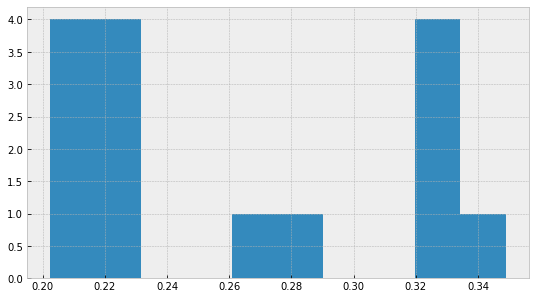

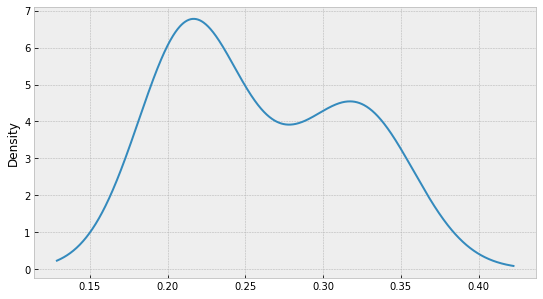

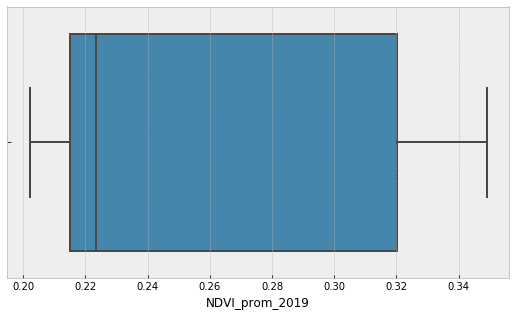

In [369]:
ndvi_2019 = data_lotes_grupo_02['NDVI_prom_2019']

# histograma
ndvi_2019.hist()
plt.show()

# gráfico de densidad
ndvi_2019.plot(kind='kde')
plt.show()

# boxplot
sb.boxplot(ndvi_2019)
plt.show()

In [348]:
print(data_lotes_grupo_02.corr())
print(data_lotes_grupo_02.corr(method='spearman'))

                Rend_Kg/Ha  NDVI_prom_2019
Rend_Kg/Ha        1.000000        0.954222
NDVI_prom_2019    0.954222        1.000000
                Rend_Kg/Ha  NDVI_prom_2019
Rend_Kg/Ha            1.00            0.85
NDVI_prom_2019        0.85            1.00


### En resumen, podemos considerar que existe una correlación entre los valores de NDVI promedio y el rendimento de los cultivos de los lotes, la cual parece ser más fuerte en el grupo 02 definido en este análisis. No obstante, habría que estudiar con mayor profundidad este grupo ya que la evidencia indica que podríamos dividirlo y analizarlo en dos grupos aparte.